# 2. Užduotis

In [29]:
set.seed(314)

utils <- source("../src/utils.R")$value
library(latex2exp)

Naudodami atvirkštinės transformacijos metodą, sumodeliuokite atsitiktinio dydžio $T$, turinčio Veibulo skirstinį su parametrais $\eta$ ir $\nu$, t.y. a. d. $T$ pasiskirstymo funkcija yra

$$
F(t; \eta, \nu) = 1 − \exp{\{-{(t/\eta)}^\nu\}},
$$

didumo $n = 100$ paprastąją atsitiktinę imtį. Atlikite užduotis:

In [30]:
n <- 100
eta <- 2 # laisvai pasirinkti 
nu <- 2

weibull_inverse_cdf <- function(theta) {
    function(probs) {
        theta[1] * (-1 * log(1 - probs)) ^ (1 / theta[2])
    }
}

observ <- weibull_inverse_cdf(c(eta, nu))(runif(n))

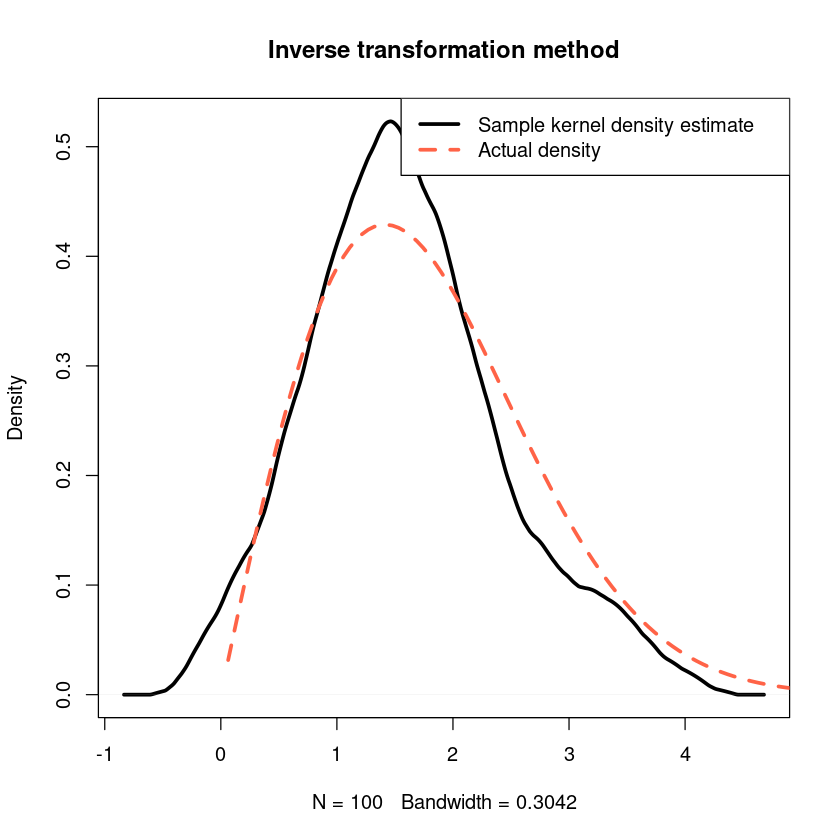

In [31]:
## Imties tankio įvertis
dens <- utils$kernel_density_estimate(observ)

## Teorinis tankis
lo <- qweibull(0.001, eta, nu)
hi <- qweibull(0.999, eta, nu)
x <- seq(lo, hi, length.out = 100)

plot(dens, main = "Inverse transformation method", col = "black", lwd = 3)
lines(x, dweibull(x, eta, nu), col = "tomato", lwd = 3, lty = 2)
legend(
    "topright",
    legend = c("Sample kernel density estimate", "Actual density"),
    col = c("black", "tomato"),
    lty = c(1, 2),
    lwd = c(3, 3)
)

a) Įrodykite, jeigu $X$ skirstinys yra Veibulo, t.y. $X \sim W(\eta, \nu)$;
$F(x; \eta, \nu) = 1 − \exp{\{-{(t/\eta)}^\nu\}}$, tai $Y = \ln{X}$ skirstinys yra $F(y) = 1 - \exp{\{ - e^{(y - \mu)/\sigma}\}}$, $\sigma = 1 / \nu$, $\mu = \ln{\eta}$.

$$
\begin{align}
F_Y(y) &= P(Y \leq y) \\
&= P(\ln X \leq y) \\
&= P(X \leq e^y) \\
&= F_X(e^y; \eta, \nu) \\
&= 1 - \exp \{ - {\big(\frac{e^y}{\eta}\big)}^\nu \} \\
&= 1 - \exp \{ - \exp \{ (y - \ln \eta) \nu \} \} \\
&= 1 - \exp \{ - \exp \{ \frac{y - \mu}{\sigma} \} \}
\end{align}
$$

b) Parinkite pradinį artinį. **Pastaba:** $X \sim W(\eta, \nu)$; $Y = \ln{X}$; $\mathbb{E}Y = \mu - \gamma \sigma$, $\gamma = 0.5772156$; $\mathbb{V}Y = {(\pi \sigma)}^2 / 6$

Naudokimės momentų metodu:

$$
\begin{align}
\hat{\mu} &= \bar{Y} + \gamma \hat{\sigma} \\
\hat{\sigma} &= \frac{\sqrt{6s^2}}{\pi}
\end{align}
$$

In [52]:
gamma <- 0.5772156
sigma_hat_moment <- function(x) { sqrt(6 * var(x)) / pi }
mu_hat_moment <- function(x) { mean(x) + gamma * sigma_hat_moment(x) }

In [53]:
observ_Y <- log(observ)
(estimate_sigma <- sigma_hat_moment(observ_Y))
(estimate_mu <- mu_hat_moment(observ_Y))

[1] 0.5210269

[1] 0.5992427

c) Naudodami `R` programos funkciją `maxLik`, `optim` arba kitą `R` optimizavimo funkciją
didžiausiojo tikėtinumo metodu įvertinkite parametrus $\eta$ ir $\nu$. Palyginkite su tikromis parametrų
reikšmėmis.

In [54]:
(start_eta <- exp(estimate_mu))
(start_nu <- 1 / estimate_sigma)

[1] 1.820739

[1] 1.919287

In [55]:
weibull_loglik <- function(observ) {
    log_sum <- sum(log(observ))
    n <- length(observ)

    function(theta) {
        eta <- theta[1]
        nu <- theta[2]
        
        n * (log(eta) - log(nu))
        - (1 / nu^eta) * sum(observ^eta)
        + (eta - 1) * (log_sum - n * log(nu))
    }
}

In [60]:
optim_optimiser <- function(f, start) {
    mle <- stats::optim(
        start, f,
        method = "L-BFGS-B",
        hessian = TRUE
    )
    r <- list(
        estimates = mle$par,
        hessian = mle$hessian
    )
    return(r)
}

mle_estimator <- function(loglikelihood, optimiser) {
    function(data, start) {
        optimiser(loglikelihood(data), start)
    }
}

weibull_mle_estimator <- mle_estimator(weibull_loglik, optim_optimiser)

In [63]:
(theta_hat_mle <- weibull_mle_estimator(observ, c(start_eta, start_nu)))

-8.881784e-10,-52.10270
-5.210270e+01,22.28055


d) Tarkime, kad modeliuoti duomenys žymi gaminio darbo laiką. Įvertinkite tikimybę,
kad gaminys dirbs ilgiau negu laiką t. Raskite laiko momentą iki kurio sugenda 30% gaminių.

In [114]:
# Tikimybė kad gaminys dirbs ilgiau negu laiką t
# => išgyvenamumo funkcija S(t) = 1 - F(t)
weibull_cdf <- function(eta, nu) {
    function(t) {
        1 - exp( -1 * (t / eta)^nu)
    }
}

weibull_survival <- function(eta, nu) {
    cdf <- weibull_cdf(eta, nu)
    function(t) {
        1 - cdf(t)
    }
}

In [115]:
eta_hat_mle <- theta_hat_mle$estimates[1]
nu_hat_mle <- theta_hat_mle$estimates[2]
survival_hat <- weibull_survival(eta_hat_mle, nu_hat_mle)

In [128]:
# Laiko momentas iki kurio sugenda 30% gaminių
(q70_actual <- qweibull(0.7, eta, nu))
(q70_hat <- qweibull(0.7, eta_hat_mle, nu_hat_mle))

[1] 2.194514

[1] 2.125283

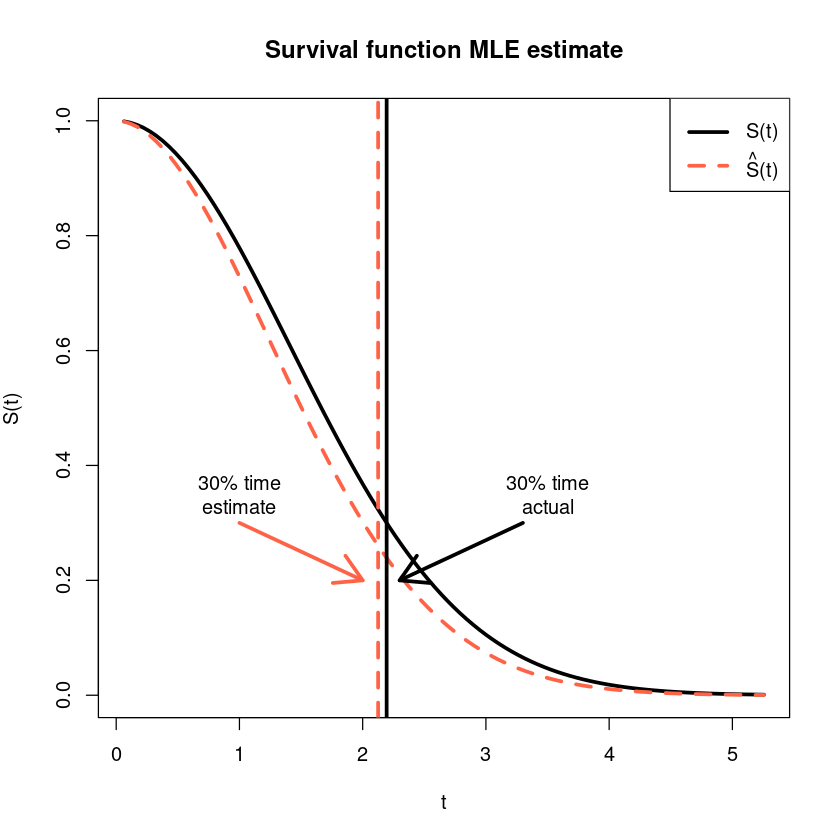

In [149]:
plot(x, 1 - pweibull(x, eta, nu),
     main = "Survival function MLE estimate",
     col = "black", lwd = 3, type = "l",
     xlab = TeX("$t$"), ylab = TeX("$S(t)$"))
lines(x, survival_hat(x), col = "tomato", lwd = 3, lty = 2)
abline(v = q70_actual, col = "black", lwd = 3)
abline(v = q70_hat, col = "tomato", lwd = 3, lty = 2)
legend(
    "topright",
    legend = c(TeX("$S(t)$"), TeX("$\\hat{S}(t)$")),
    col = c("black", "tomato"),
    lty = c(1, 2),
    lwd = c(3, 3)
)

arrows(x0 = c(3.3, 1), y0 = c(0.3, 0.3),
       x1 = c(2.3, 2), y1 = c(0.2, 0.2), 
       col = c("black", "tomato"), lwd = 3)
text(x = c(3.5, 1), y = c(0.35, 0.35),
     col = c("black", "black"),
     labels = c( "30% time\nactual", "30% time\nestimate"))